# AQI 24h Prediction + Personalized Health Impact Score
This notebook trains an XGBoost time-series model to forecast the **next 24 hours of AQI** and computes a **Personalized Health Impact Score (HIS)** per hour using user inputs (age, breathing rate, outdoor habits, mask).

**How to use**

1. Upload your hourly CSV (e.g., `DwarkaSec8_Hourly.csv`) via the Colab file pane.

2. Run the cells. The notebook will auto-detect the datetime and AQI columns.

3. At the end you'll get a 24-hour forecast and HIS table, plus a saved model `aqi_model.pkl` for a future PyQt GUI.

> ⚠️ This is for educational purposes, not medical advice.



In [2]:
!pip install xgboost joblib pandas matplotlib scikit-learn pyqt5


In [4]:

# If running on Colab, uncomment the next line to install dependencies:
# !pip install xgboost joblib pandas scikit-learn matplotlib

import pandas as pd
import matplotlib.pyplot as plt

from aqi_model import TrainConfig, train_from_csv, save_model
from health_score import UserProfile, compute_hourly_his, summarize_his


In [6]:
from aqi_model import smart_guess_columns, prepare_timeseries, TrainConfig
import pandas as pd


In [8]:
# Path to your uploaded CSV
CSV_PATH = "DwarkaSec8_Hourly.csv" # change if different

In [10]:
df = pd.read_csv("DwarkaSec8_Hourly.csv", index_col=0)

# Create datetime column
df["datetime"] = pd.to_datetime(
    df[["year", "month", "day", "hour"]]
)


In [12]:
df.head()


,PM2.5,year,month,day,hour,PM10,AT,BP,SR,RH,...,WD,NO,NO2,SO2,Ozone,CO,Benzene,NH3,NOx,datetime
0,61.0,2018.0,6.0,1.0,0.0,284.0,34.77,976.00,9.08,41.00,...,107.17,2.940,14.860,6.98,48.790000,1.14,0.2000,60.50,17.78,2018-06-01 00:00:00
1,63.0,2018.0,6.0,1.0,1.0,262.0,34.40,976.00,9.00,41.50,...,103.67,2.300,14.430,5.58,49.250000,1.06,0.2400,51.95,20.10,2018-06-01 01:00:00
2,74.0,2018.0,6.0,1.0,2.0,218.0,33.48,976.00,9.00,44.25,...,116.83,2.300,10.200,0.38,60.900000,0.13,0.8000,1.18,4.53,2018-06-01 02:00:00
3,53.0,2018.0,6.0,1.0,3.0,208.0,32.57,976.00,9.00,48.08,...,146.75,2.503,12.253,0.40,66.099000,0.05,0.7625,0.63,0.17,2018-06-01 03:00:00
4,117.0,2018.0,6.0,1.0,4.0,241.0,32.07,976.08,9.00,53.25,...,151.08,2.706,14.306,0.40,71.298004,0.04,0.7250,0.60,0.20,2018-06-01 04:00:00


In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 11704 entries, 0 to 11703
Data columns (total 21 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   PM2.5     11704 non-null  float64       
 1   year      11704 non-null  float64       
 2   month     11704 non-null  float64       
 3   day       11704 non-null  float64       
 4   hour      11704 non-null  float64       
 5   PM10      11704 non-null  float64       
 6   AT        11704 non-null  float64       
 7   BP        11704 non-null  float64       
 8   SR        11704 non-null  float64       
 9   RH        11704 non-null  float64       
 10  WS        11704 non-null  float64       
 11  WD        11704 non-null  float64       
 12  NO        11704 non-null  float64       
 13  NO2       11704 non-null  float64       
 14  SO2       11704 non-null  float64       
 15  Ozone     11704 non-null  float64       
 16  CO        11704 non-null  float64       
 17  Benzene   11704 n

In [16]:
df.columns


Index(['PM2.5', 'year', 'month', 'day', 'hour', 'PM10', 'AT', 'BP', 'SR', 'RH',
       'WS', 'WD', 'NO', 'NO2', 'SO2', 'Ozone', 'CO', 'Benzene', 'NH3', 'NOx',
       'datetime'],
      dtype='object')

In [18]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 11704 entries, 0 to 11703
Data columns (total 21 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   PM2.5     11704 non-null  float64       
 1   year      11704 non-null  float64       
 2   month     11704 non-null  float64       
 3   day       11704 non-null  float64       
 4   hour      11704 non-null  float64       
 5   PM10      11704 non-null  float64       
 6   AT        11704 non-null  float64       
 7   BP        11704 non-null  float64       
 8   SR        11704 non-null  float64       
 9   RH        11704 non-null  float64       
 10  WS        11704 non-null  float64       
 11  WD        11704 non-null  float64       
 12  NO        11704 non-null  float64       
 13  NO2       11704 non-null  float64       
 14  SO2       11704 non-null  float64       
 15  Ozone     11704 non-null  float64       
 16  CO        11704 non-null  float64       
 17  Benzene   11704 n

In [20]:
len(df)

11704

In [22]:
df["datetime"].head()
df["datetime"].tail()


11699   2019-10-01 11:00:00
11700   2019-10-01 12:00:00
11701   2019-10-01 13:00:00
11702   2019-10-01 14:00:00
11703   2019-10-01 15:00:00
Name: datetime, dtype: datetime64[ns]

In [24]:
df["PM2.5"].isna().sum()


0

In [26]:
df[["datetime","PM2.5"]].dropna().shape


(11704, 2)

In [28]:
df[["datetime","PM2.5"]].head()


,datetime,PM2.5
0,2018-06-01 00:00:00,61.0
1,2018-06-01 01:00:00,63.0
2,2018-06-01 02:00:00,74.0
3,2018-06-01 03:00:00,53.0
4,2018-06-01 04:00:00,117.0


In [30]:
df["datetime"].diff().value_counts().head(10)


datetime
0 days 01:00:00    11703
Name: count, dtype: int64

In [32]:
cfg = TrainConfig(
    dt_col="datetime",
    target_col="PM2.5"
)

prepared = prepare_timeseries(df[["datetime","PM2.5"]], cfg)
prepared.shape


C:\Users\harsh\Aqi_predicter\aqi_model.py:104: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df = df.set_index(dt_col).asfreq(cfg.freq)


(11632, 85)

In [34]:
from aqi_model import split_train_test

prepared = prepare_timeseries(df[["datetime","PM2.5"]], cfg)
train, test = split_train_test(prepared, cfg)

print("prepared:", prepared.shape)
print("train:", train.shape)
print("test:", test.shape)


prepared: (11632, 85)
train: (11464, 85)
test: (168, 85)


C:\Users\harsh\Aqi_predicter\aqi_model.py:104: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df = df.set_index(dt_col).asfreq(cfg.freq)


In [36]:
cfg = TrainConfig(
    dt_col="datetime",
    target_col="PM2.5",
    lag_hours=24,
    roll_windows=(6, 12),
    n_splits=2,
    test_size_hours=24*3,
    freq="h"
)

art = train_from_csv("Dwarka_clean.csv", cfg)
art["cv_mae"], art["test_mae"], art["dt_col"], art["target_col"]


(0.0, 2.7334403522809345, 'datetime', 'NOx')

In [38]:

# Save model for later GUI use
_ = save_model(art["model"], art["cfg"], path="aqi_model.pkl")
print("Saved model to aqi_model.pkl")


Saved model to aqi_model.pkl


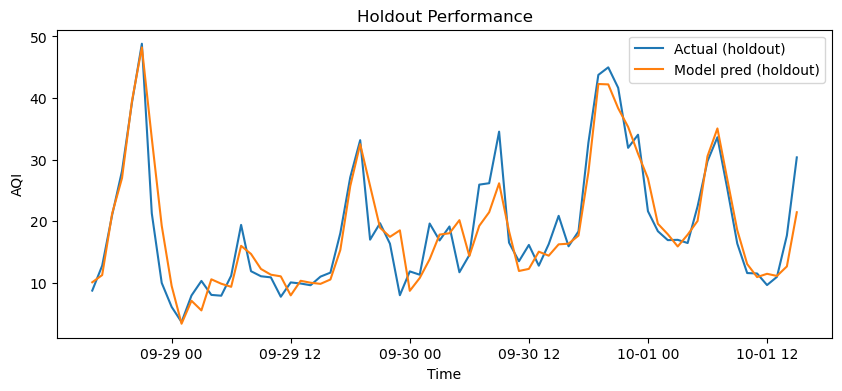

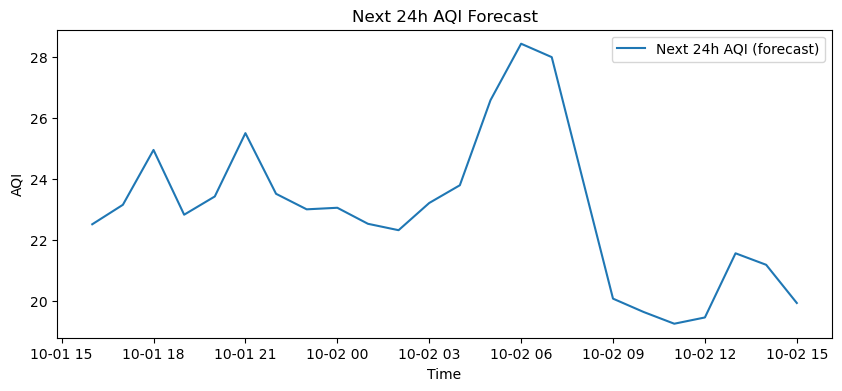

In [38]:

# Plot actual vs pred on the holdout and show next 24h forecast
test = art["test"]
forecast_24h = art["forecast_24h"]

plt.figure(figsize=(10,4))
plt.plot(test.index, test[art["cfg"].target_col], label="Actual (holdout)")
plt.plot(test.index, test["pred"], label="Model pred (holdout)")
plt.legend(); plt.title("Holdout Performance"); plt.xlabel("Time"); plt.ylabel("AQI"); plt.show()

plt.figure(figsize=(10,4))
plt.plot(forecast_24h.index, forecast_24h.values, label="Next 24h AQI (forecast)")
plt.title("Next 24h AQI Forecast"); plt.xlabel("Time"); plt.ylabel("AQI"); plt.legend(); plt.show()


In [40]:

# Compute Personalized Health Impact Score (HIS)

# Example user inputs — change to your values
profile = UserProfile(
    age=22,
    breathing_rate_lpm=10.0,       # in liters/minute
    outdoor_hours_per_day=3.0,
    mask="surgical",               # "none" | "surgical" | "n95"
)

his = compute_hourly_his(art["forecast_24h"], profile)
summary = summarize_his(his)
pd.DataFrame({"predicted_AQI": art["forecast_24h"], "HIS": his}), summary


C:\Users\harsh\Aqi_predicter\health_score.py:67: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  pred_aqi = pred_aqi.fillna(method="ffill")


(                     predicted_AQI        HIS
 2019-10-01 16:00:00      22.526030  15.484305
 2019-10-01 17:00:00      23.164783  15.510317
 2019-10-01 18:00:00      24.964161  15.584769
 2019-10-01 19:00:00      22.839563  15.497046
 2019-10-01 20:00:00      23.437641   8.869426
 2019-10-01 21:00:00      25.514833   8.918803
 2019-10-01 22:00:00      23.525362   8.871484
 2019-10-01 23:00:00      23.015995   8.859565
 2019-10-02 00:00:00      23.067232   8.860760
 2019-10-02 01:00:00      22.541466   8.848532
 2019-10-02 02:00:00      22.331490   8.843672
 2019-10-02 03:00:00      23.223812   8.864418
 2019-10-02 04:00:00      23.805727   8.878078
 2019-10-02 05:00:00      26.594074   8.944987
 2019-10-02 06:00:00      28.447573   8.990814
 2019-10-02 07:00:00      28.007782   8.979842
 2019-10-02 08:00:00      24.039207  15.546280
 2019-10-02 09:00:00      20.086397  15.386942
 2019-10-02 10:00:00      19.648994  15.369814
 2019-10-02 11:00:00      19.264118  15.354826
 2019-10-02 1

In [42]:

# Export the 24h forecast + HIS to CSV for the GUI (or other apps)
out_df = pd.DataFrame({"predicted_AQI": art["forecast_24h"], "HIS": compute_hourly_his(art["forecast_24h"], profile)})
out_df.to_csv("forecast_24h_with_HIS.csv")
print("Saved forecast to forecast_24h_with_HIS.csv")
out_df.tail()


Saved forecast to forecast_24h_with_HIS.csv


C:\Users\harsh\Aqi_predicter\health_score.py:67: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  pred_aqi = pred_aqi.fillna(method="ffill")


,predicted_AQI,HIS
2019-10-02 11:00:00,19.264118,15.354826
2019-10-02 12:00:00,19.469530,15.362816
2019-10-02 13:00:00,21.574053,15.445940
2019-10-02 14:00:00,21.196497,15.430857
2019-10-02 15:00:00,19.944254,15.381365


In [ ]:
!python gui_stub.py

In [ ]:
import inspect
import aqi_model
print(inspect.getsource(aqi_model.train_from_csv))


In [46]:
pd

<module 'pandas' from 'C:\\Users\\harsh\\anaconda3\\Lib\\site-packages\\pandas\\__init__.py'>

In [39]:
import pandas
print(pandas)
print(pd)


<module 'pandas' from 'C:\\Users\\harsh\\anaconda3\\Lib\\site-packages\\pandas\\__init__.py'>
<module 'pandas' from 'C:\\Users\\harsh\\anaconda3\\Lib\\site-packages\\pandas\\__init__.py'>


In [50]:
import PyQt5
print("Using PyQt5")


Using PyQt5
